In [1]:
__author__ = 'David Herrera <david.herrera@noirlab.edu>, Robert Nikutta <robert.nikutta@noirlab.edu> and the Astro Data Lab Team <datalab@noirlab.edu>'
__version__ = '20250109' # yyyymmdd
__datasets__ = ['ls_dr6','ls_dr7','ls_dr8','ls_dr9','allwise']
__keywords__ = ['extragalactic','galaxies','joint query','legacy survey','desi']
__nbid__ = '0068'

# DESI Legacy Imaging Survey (LIS) 
## Coverage, Magnitudes and comparison with AllWISE 

### Table of contents
* [Goals & Summary](#goals)
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#import)
* [Sky coverage of the DESI Legacy Imaging Surveys](#Fig2)
* [LS and WISE mid-infrared (W1) photometry comparisons](#Fig8)
* [Survey depth for point sources](#Fig15)
* [Color-color distributions by object type](#Fig16)
* [Resources and references](#resources)

<a class="anchor" id="goals"></a>
# Goals
This notebook reproduces several figures from the DESI Legacy Imaging Surveys (LS) overview paper ([Dey et al., 2019](https://ui.adsabs.harvard.edu/abs/2019AJ....157..168D/abstract)). It uses catalogs from LS Data Releases 6, 7 (both showcased in the paper), and the newer DR 8 and 9, as well as from the AllWISE survey. All tables are hosted at Astro Data Lab and are queried using the Data Lab TAP service.

# Summary

The DESI Legacy Imaging Surveys are a set of photometric surveys conducted for target identification for the Dark Energy Spectroscopic Instrument (DESI) survey, currently underway on the NOIRLab/Kitt Peak Mayall 4m telescope. Once finished, the DESI Survey will feature up to 40 million individual galaxy spectra, and help answer questions about the nature of Dark Energy in the universe.

The Legacy Imaging Surveys comprise three individual surveys:

- Dark Energy Camera Legacy Survey (DECaLS)
- Beijing-Arizona Sky Survey (BASS)
- Mayall z-band Legacy Survey (MzLS)

of the Northern sky, collected on the Kitt Peak National Observatory (KPNO) and the Cerro Tololo Inter-American Observatory (CTIO). Jointly these surveys have imaged over 14,000 square degrees in the g, r, and z bands.

In this notebook we will reproduce several figures from the overview paper:

- Fig 2: Query the catalogs for LS healpixel positions and construct an all-sky map (from LS DR8)
- Fig 8: Comparing the distributions of WISE W1 magnitudes extracted from the AllWISE survey, and forced photometry using the LS pipeline (from LS DR7, AllWISE)
- Fig 15: Compare the distribution of PSF depth for point sources (from LS DR6, 7, 9)
- Fig 16: Query and plot the color-color distribution of sources using the g, r, and z magnitudes (from LS DR7)

We used catalogs from the DESI Legacy Imaging Survey DR6, DR7 (both now retired from Data Lab), DR8 & DR9 (the latest more complete and stable DR), and AllWISE.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution

Disclaimers
-----------
Please note that using the Astro Data Lab and its resources is covered by some minimal [Disclaimers](https://datalab.noirlab.edu/disclaimers.php).

Acknowledgments
---------------
If you use **Astro Data Lab** in your published research, please include the text in your paper's Acknowledgments section:

_This research uses services or data provided by the Astro Data Lab, which is part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

If you use **SPARCL jointly with the Astro Data Lab platform** (via JupyterLab, command-line, or web interface) in your published research, please include this text below in your paper's Acknowledgments section:

_This research uses services or data provided by the SPectra Analysis and Retrievable Catalog Lab (SPARCL) and the Astro Data Lab, which are both part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

In either case **please cite the following papers**:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, https://doi.org/10.1117/12.2057445

* Astro Data Lab overview: Nikutta et al., "Data Lab - A Community Science Platform", Astronomy and Computing, 33, 2020, https://doi.org/10.1016/j.ascom.2020.100411

If you are referring to the Data Lab JupyterLab / Jupyter Notebooks, cite:

* Juneau et al., "Jupyter-Enabled Astrophysical Analysis Using Data-Proximate Computing Platforms", CiSE, 23, 15, 2021, https://doi.org/10.1109/MCSE.2021.3057097

If publishing in a AAS journal, also add the keyword: `\facility{Astro Data Lab}`

And if you are using SPARCL, please also add `\software{SPARCL}` and cite:

* Juneau et al., "SPARCL: SPectra Analysis and Retrievable Catalog Lab", Conference Proceedings for ADASS XXXIII, 2024
https://doi.org/10.48550/arXiv.2401.05576

The NOIRLab Library maintains [lists of proper acknowledgments](https://noirlab.edu/science/about/scientific-acknowledgments) to use when publishing papers using the Lab's facilities, data, or services.

<a class="anchor" id="import"></a>
# Imports and setup
We first import several standard Python packages used in this notebook, and the Data Lab query client and authentication client.

In [2]:
# std lib
from getpass import getpass

# 3rd party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
import healpy as hp
from astropy.table import Table
from astropy import units as u

# Data Lab
from dl import queryClient as qc, authClient as ac

Some of Data Lab's services require that the user be logged in. We obtain a valid login token:

<a class="anchor" id="auth"></a>
# Authentication
Much of the functionality of Data Lab can be accessed without explicitly logging in (the service then uses an anonymous login). But some capacities, for instance saving the results of your queries to your virtual storage space, require a login (i.e. you will need a registered user account).

If you need to log in to Data Lab, un-comment the cell below and execute it:

In [3]:
#token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
#ac.whoAmI()

<a class="anchor" id="Fig2"></a>
# Fig. 2 - Sky coverage of the DESI Legacy Imaging Surveys

An all-sky map showing the survey coverage can be constructed by querying the survey object table for the complete list of healpixels (which are uniquely numbered) that contain sources. A source density map can be easily constructed if we also count the number of sources per healpixel.

In contrast to the DESI Legacy Imaging Surveys overview paper we will use LS DR8 here (up from DR7) because it contains more data in the Northern hemisphere (from the MLzS and BASS surveys).

In [4]:
# This will run for about 3-4 minutes
query_fig2 = "SELECT nest4096, COUNT(nest4096) AS n FROM ls_dr8.tractor GROUP BY nest4096"
dfm = qc.query(query_fig2,timeout=600,fmt='pandas')

Next let's define a few helper functions for computing the survey area, and the sky map:

In [5]:
def compute_survey_area(df,res=12):
    """Determine the size of a healpixel in DataFrame `df`,
    and the total area covered by all healpixels.
    
    Params:
    -------
    df : DataFrame
        DataFrame containing the healpixels of the survey.

    res : int
        Healpixel resolution (as level; nside = 2**res)

    Returns:
    --------
    areapix : astropy.units.quantity.Quantity
        Size of one healpixel area in `df`, in square degrees.

    areasurvey : astropy.units.quantity.Quantity
        The sum of all unique healpixels in `df` (the survey area), in square degrees.
    """
    
    areasky = ((360*u.deg)**2)/np.pi
    nside = 2**res
    npix = 12*nside**2
    areapix = areasky / npix
    areasurvey = df.shape[0]*areapix
    return areapix, areasurvey
    
def compute_healpix_map(df,areapix,newnside=None):
    """Compute a healpix map from a two columns in a DataFrame.
    
    Params:
    -------
    df : DataFrame
        Must contain a nest4096 column (the nest4096 healpixel number, and n, the source count in that healpixel.

    areapix : astropy.units.quantity.Quantity
        Size of one healpixel area in `df`. `areapix` is one of the return values of `func:compute_survey_area`.

    newnsize : int
        If `newnside` is not None, the healpix map will be resampled. Values for `newnside` are powers of 2,
        and typically are, e.g., 512,1024,2048, etc.

    Returns:
    --------
    tmap : np.array
        The healpixel map as a 2D numpy array.
    """
    
    tmap = np.zeros(hp.nside2npix(4096))
    tmap[df['nest4096']] = df['n']/areapix
    if newnside is not None:     
        tmap = hp.ud_grade(tmap,newnside,order_in='NESTED',order_out='NESTED')
    return tmap

Given the DataFrame dfm with our healpixels and their counts, let's compute the survey area, healpixel area, and the sky map:

In [6]:
areapix, areasurvey = compute_survey_area(dfm)
m = compute_healpix_map(dfm,areapix)

Now, we finally plot our map

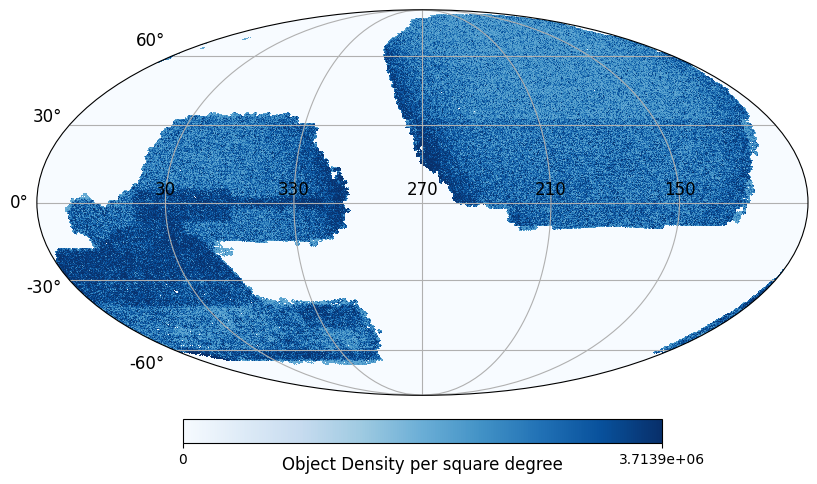

In [7]:
# Here we plot the map
fig2 = hp.projview(
    m,
    norm='hist',
    projection_type='mollweide',
    rot=(-90,0,0),
    coord='C',
    nest=True,
    cmap='Blues',
    graticule=True,
    graticule_labels=True,
    custom_xtick_labels=["30","330","270","210","150"],
    unit=r'Object Density per square degree'
)

<a class="anchor" id="Fig8"></a>
# Fig. 8 - LS and WISE mid-infrared (W1) photometry comparisons 

The Legacy Survey produced forced photometry measurements with [The Tractor](https://thetractor.org/about/) code. In the following plot, we compare it to the 'native' WISE photometry from the AllWISE survey.

First, we obtain the positions and W1 magnitudes of all sources in the same 5x5 square degree patch of the sky, both from the LS DR7 object table named 'tractor', and the AllWISE object table named 'source'.

A few note of interest:

- LS data releases 7 and lower have been retired from Data Lab, since they have been superseded by later DRs. For the purpose of this notebook, and to reproduce figures from the DESI Imaging Legacy Survey overview paper, Data Lab does maintain a few earlier LS tables in a database schema called 'nbdata'.

- In our queries we will also reject rows where the W1 magnitudes are 'nan' -- undefined.

- We will save the results of the two first queries as tables in MyDB, our remote database system for your own tables.

- Finally, note that because AllWISE reports magnitudes in the Vega system, and LS in the AB system, we apply a zero-point shift of 2.699 mags for W1 in the LS query to bring its W1 magnitudes to the Vega system.

Define the min and max RA and Dec value for the sky patch

In [8]:
ramin, ramax = 150, 155
decmin, decmax = 10, 15

Define the LS query as an SQL string

In [9]:
qls = """SELECT ra,dec,mag_w1 - 2.699 AS mag_w1
FROM nbdata.nb0068_lsdr7_tractor
WHERE ra BETWEEN %d AND %d
AND dec BETWEEN %d AND %d
AND mag_w1 != 'nan'""" % (ramin,ramax,decmin,decmax)

print(qls)

SELECT ra,dec,mag_w1 - 2.699 AS mag_w1
FROM nbdata.nb0068_lsdr7_tractor
WHERE ra BETWEEN 150 AND 155
AND dec BETWEEN 10 AND 15
AND mag_w1 != 'nan'


Let's execute this query. With a 5x5 square degree patch it should run just about 10-15 seconds:

In [10]:
# Save to mydb the table with all LS W1 measurements in our sky patch.
# drop=True will first delete a table in MyDB, should one with the same name already exist.
qc.query(qls,timeout=600,out='mydb://lstab',drop=True)

'OK'

Soon we will JOIN (on a positional index) this table and the one resulting from the AllWISE query. It's a good idea to compute the index now. Data Lab uses Q3C for spatial indexing: 

In [11]:
# Args are: name of table in MyDB, coordinate column names that contain RA and Dec,
# and whether to cluster the table on the new Q3C index
qc.mydb_index('lstab',q3c='ra,dec',cluster=True)

'OK'

Let's now load this table into memory as a Pandas DataFrame

In [12]:
dfls = qc.query("select * from mydb://lstab",fmt='pandas')

How many rows and columns does this table contain?

In [13]:
dfls.shape

(1332446, 3)

Let's take a look at the first five rows

In [14]:
dfls.head(5)

,ra,dec,mag_w1
0,150.249112,10.001329,15.096534
1,150.253003,10.000394,16.175163
2,150.258017,10.000163,19.206575
3,150.261400,10.000670,20.411222
4,150.272552,10.000478,16.072210


We now define, run, save to MyDB, index, and load into memory a similar query on the AllWISE object table (called 'source')

In [15]:
qaw = """SELECT ra,dec,w1mpro
FROM allwise.source
WHERE ra BETWEEN %d AND %d
AND dec BETWEEN %d AND %d
AND w1mpro != 'nan'
""" % (ramin,ramax,decmin,decmax)

print(qaw)

SELECT ra,dec,w1mpro
FROM allwise.source
WHERE ra BETWEEN 150 AND 155
AND dec BETWEEN 10 AND 15
AND w1mpro != 'nan'



In [16]:
qc.query(qaw,timeout=600,out='mydb://allwisetab',drop=True)

'OK'

In [17]:
qc.mydb_index('allwisetab',q3c='ra,dec',cluster=True)

'OK'

In [18]:
dfaw = qc.query("select * from mydb://allwisetab",fmt='pandas')

In [19]:
dfaw.shape

(335060, 3)

We can already see that LS DR8 contains over 4x as many sources with valid W1 magnitudes as AllWISE (in this particular sky patch).

Let's now define and run a query that positinally joins the two tables we just saved to MyDB. This uses the Q3C index (which is very fast), and the resulting table contains the W1 magnitudes from both tables, but only for (RA,Dec) positions that are less than one arcsecond apart from each other in both tables.

In [20]:
qx = """SELECT l.mag_w1, a.w1mpro
FROM mydb://lstab AS l, mydb://allwisetab AS a
WHERE Q3C_JOIN(a.ra,a.dec,l.ra,l.dec,1/3600.) 
"""

print(qx)

SELECT l.mag_w1, a.w1mpro
FROM mydb://lstab AS l, mydb://allwisetab AS a
WHERE Q3C_JOIN(a.ra,a.dec,l.ra,l.dec,1/3600.) 



In [21]:
dfx = qc.query(qx,timeout=600,fmt='pandas')

In [22]:
dfx.shape

(239310, 2)

There are over 239k rows in our crossmatched / joined table. The first few rows:

In [23]:
dfx.head(5)

,mag_w1,w1mpro
0,16.175163,16.090
1,16.072210,15.919
2,17.539886,17.422
3,16.663936,16.649
4,16.899995,16.997


This table may contain a few invalid entries (NaNs, Infs). Let's remove them:

In [24]:
dfx.replace([np.inf, -np.inf], np.nan, inplace=True)
dfx.dropna(inplace=True)
dfx.reset_index(inplace=True, drop=True)

In [25]:
dfx.shape

(239302, 2)

We can now plot both panels of Fig. 8 in the overview paper.

The left panel plots the W1 magnitudes of the same objects from AllWISE on the x-axis and from LS on the y-axis. This is why we needed these W1 measurements to be cross-matched positionally on the sky.

The right panel shows the histograms of all sources found in the same sky patch in both surveys. LS extracted forced photometry measurements, hence detecting more sources, and specifically those fainter than the native detection limit of WISE.

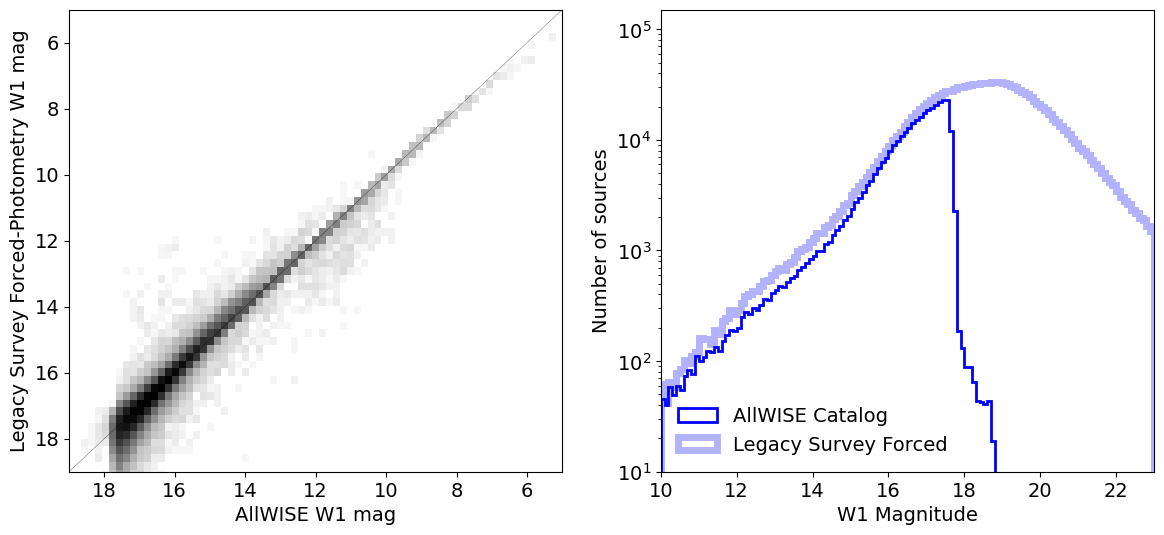

In [26]:
plt.rcParams['font.size'] = 14
fig, (ax0,ax1) = plt.subplots(1, 2, figsize = (14, 6))

# LEFT panel: W1 mags from LS vs AllWISE
nbins = 100
ax0.axline([0,0], c='black', slope=1, linewidth=0.2)
ax0.hist2d(dfx['w1mpro'],dfx['mag_w1'],bins=(nbins,nbins),norm=colors.LogNorm(),cmap='Greys')
ax0.set_xlim(19.,5.)
ax0.set_ylim(19,5.)
ax0.set(xlabel='AllWISE W1 mag', ylabel='Legacy Survey Forced-Photometry W1 mag');

# RIGHT panel: W1 distribitions for all sources in the same skypatch in either survey
bins = np.arange(10.,23.0001,0.1)
ax1.hist(dfaw['w1mpro'],bins=bins,histtype='step',color='blue',lw=2,label='AllWISE Catalog',zorder=1)
ax1.hist(dfls['mag_w1'],bins=bins,histtype='step',color='blue',lw=5,alpha=0.3,label='Legacy Survey Forced',zorder=0)
ax1.set(xlabel='W1 Magnitude', ylabel='Number of sources')
ax1.set_yscale('log')
ax1.set_xlim(10,23)
ax1.set_ylim(10,1.5e5)
ax1.legend(loc='lower left',frameon=False);

Note that in both panels we are plotting only the objects from a 5x5 area of the sky, while Fig. 8 in the overview paper shows the entire survey areas. Thus our absolute numbers are smaller, but the overall trends are very similar.

<a class="anchor" id="Fig15"></a>
# Fig. 15 - Survey depth for point sources

Now, we will calculate the depth for point sources in DRs 6, 7, and 9 for each band _g, r, z_ following the prescription in the original paper. Our queries will be against the 'bricks' tables -- survey summary tables which contain information, for instance, on the number of sources detected in each "brick".

We first define some minimum requirements for each query:

In [27]:
nmin = 1000  # Required minimum number of objects in a brick
npix = 0.9*900.*900.  # Requires that 90% of the image are to contain >= 3 exposures:

Two helper functions will help us run the queries efficiently

In [28]:
def get_colnames(band,cols=(1,2,3,4,5,6)):
    """Constructs the approproate column names in the bricks table, for all bands."""
    pattern = 'nexphist_%s_%d'
    colnames = [pattern % (band,col) for col in cols]
    return colnames

In [29]:
def run_query(table,band='g'):
    """Construct and run query for single DR and single band. Return psfdepth."""
    
    print("Running query for table '%s' and band '%s'" % (table,band))
    
    colsall = '+'.join(get_colnames(band,(1,2,3,4,5,6)))
    colsgt3 = '+'.join(get_colnames(band,(4,5,6)))
    
    q = """SELECT psfdepth_%s AS psfdepth FROM
         (SELECT *, t1.sumgt3 / NULLIF(t1.sumall,0.) AS frac FROM
           (SELECT nexp_%s, psfdepth_%s, nobjs, %s AS sumall, %s AS sumgt3 FROM %s) AS t1
            WHERE nexp_%s >= 3
            AND nobjs >= %d
            AND sumall > %d) AS t2
         WHERE frac > 0.9
    """ % (band,band,band,colsall,colsgt3,table,band,nmin,npix)

    df = qc.query(q,fmt='pandas')
    return df

We execute the query for each combination of band (g,r,z) and data release (6,7,9), and collect the resulting psfdepth tables (single column each) in a list:

In [30]:
bands = ('g','r','z')
tables = ('nbdata.nb0068_lsdr6_bricks_dr6','nbdata.nb0068_lsdr7_bricks_dr7','ls_dr9.bricks_s')
drs = ('DR6','DR7','DR9')

psfdepths = []  # to gather bands, drs, and results
for b in bands:
    for jt,t in enumerate(tables):
        df = run_query(table=t,band=b)
        psfdepths.append((b,t,drs[jt],df))

Running query for table 'nbdata.nb0068_lsdr6_bricks_dr6' and band 'g'
Running query for table 'nbdata.nb0068_lsdr7_bricks_dr7' and band 'g'
Running query for table 'ls_dr9.bricks_s' and band 'g'
Running query for table 'nbdata.nb0068_lsdr6_bricks_dr6' and band 'r'
Running query for table 'nbdata.nb0068_lsdr7_bricks_dr7' and band 'r'
Running query for table 'ls_dr9.bricks_s' and band 'r'
Running query for table 'nbdata.nb0068_lsdr6_bricks_dr6' and band 'z'
Running query for table 'nbdata.nb0068_lsdr7_bricks_dr7' and band 'z'
Running query for table 'ls_dr9.bricks_s' and band 'z'


And finally we can plot the point source 5-sigma depth curve for each band and survey:

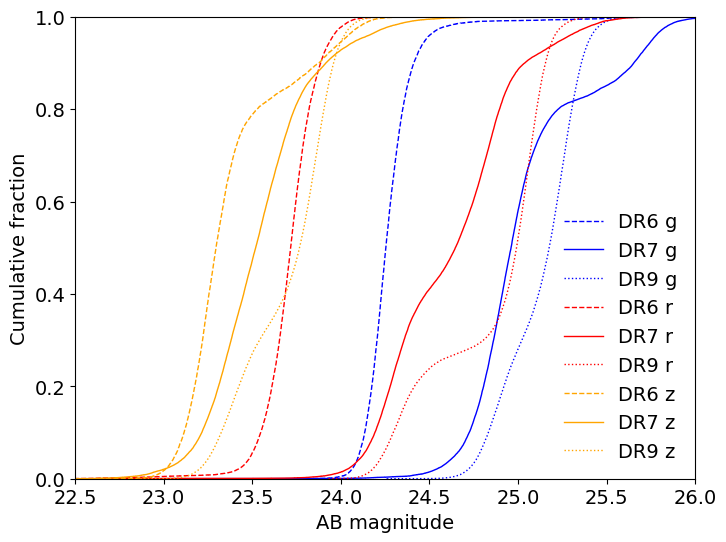

In [31]:
fig = plt.figure(figsize=(8,6))

for (b,t,dr,df) in psfdepths:
    linecolors = {'g':'blue','r':'red','z':'orange'}
    linestyles = {'DR6':'--','DR7':'-','DR9':':'}

    n = df.size
    x = np.sort(df['psfdepth'])
    y = np.array(range(n))/float(n)
    label = "%s %s" % (dr,b)
    plt.plot(x,y,color=linecolors[b],ls=linestyles[dr],lw=1,drawstyle='steps-pre',label=label)

plt.legend(loc='lower right',frameon=False)
plt.xlabel('AB magnitude')
plt.ylabel('Cumulative fraction')
plt.xlim(22.5,26.0)
plt.ylim(0,1);

Compare this to Fig. 15 in the overview paper. Note how the point-source depths for DR9 (not available at the time of publication of the overview paper) go deeper than DR7 by about 0.5-1 magnitudes in all bands.

<a class="anchor" id="Fig16"></a>
## Fig. 16 - Color-color distributions by object type

In this section, we want to plot color-color distributions of sources in LS DR7 classified by the pipeline as either PSF (point-like sources), EXP (exponential disk; spiral galaxies), or DEV (de Vaucouleurs profile; elliptical galaxies).

We construct a query string that will return a set number of rows with three colors and the source type as columns. We also exclude NaN and Inf-valued entries. Finally to ensure a randomly selected sample on the sky, we request (using random_id) that the sample members are randomly selected on the sky. 

In [32]:
query_fig16a = """SELECT r_z, g_r, z_w1, type 
FROM nbdata.nb0068_lsdr7_tractor 
WHERE (type = 'EXP' OR type = 'DEV' OR type = 'PSF')
AND (r_z != 'inf' AND r_z != 'nan')
AND (g_r != 'inf' AND g_r != 'nan')
AND (z_w1 != 'inf' AND z_w1 != 'nan')
AND random_id BETWEEN 11. AND 12.
LIMIT 300000
"""

print(query_fig16a)

SELECT r_z, g_r, z_w1, type 
FROM nbdata.nb0068_lsdr7_tractor 
WHERE (type = 'EXP' OR type = 'DEV' OR type = 'PSF')
AND (r_z != 'inf' AND r_z != 'nan')
AND (g_r != 'inf' AND g_r != 'nan')
AND (z_w1 != 'inf' AND z_w1 != 'nan')
AND random_id BETWEEN 11. AND 12.
LIMIT 300000



Run the query:

In [33]:
df = qc.query(sql=query_fig16a, fmt='pandas')
df.head(5)

,r_z,g_r,z_w1,type
0,0.079756,0.353277,-1.703598,PSF
1,0.949818,1.429455,0.788786,EXP
2,1.057819,0.778284,1.160572,EXP
3,0.315361,0.660346,-1.128406,PSF
4,0.961868,1.750929,0.748854,DEV


We can now plot our the color-color distribution, separated by object classification, as 2D histograms with overlaid contours:

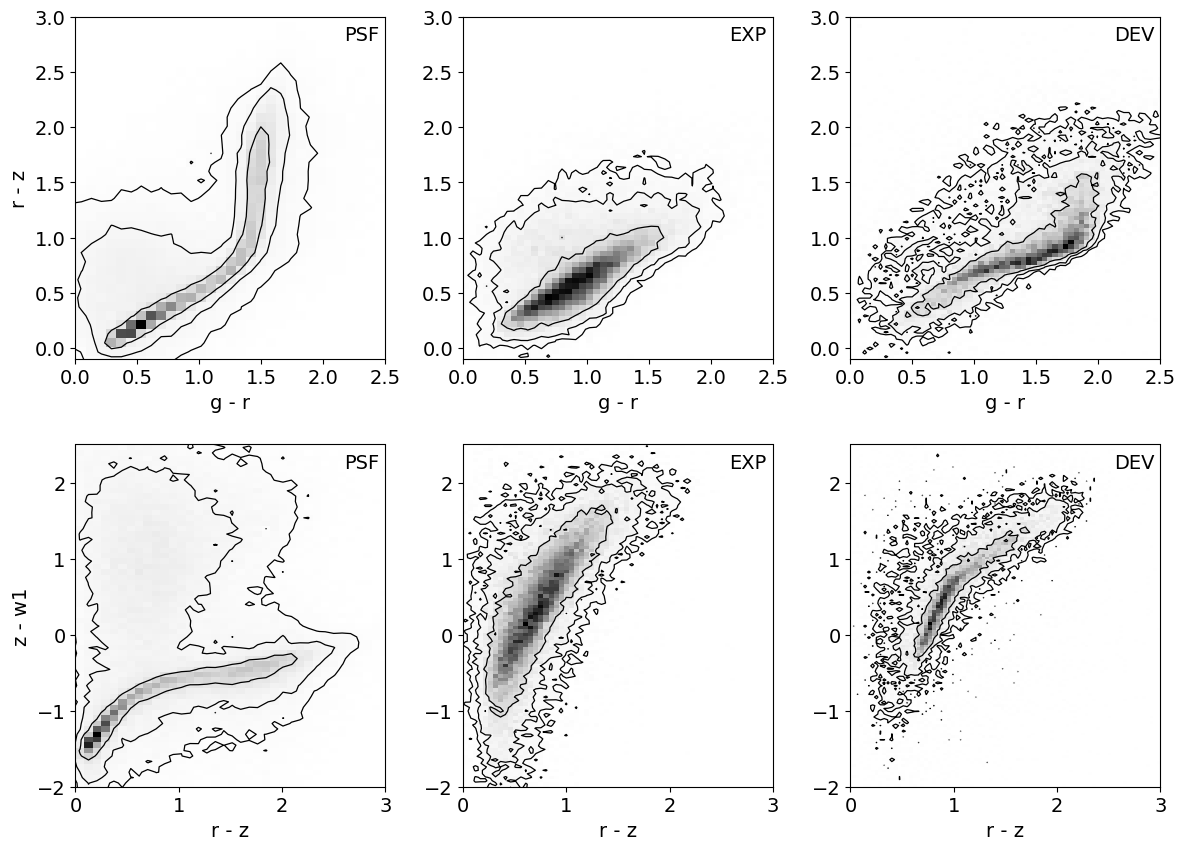

In [34]:
# Helper function to plot a single panel
def plot_panel(ax,df,typ,xcolor,ycolor,xlims,ylims,xlabel=None,ylabel=None):

    # Boolean selection by galaxy type
    cond = (df['type'] == typ)
    x = df[xcolor][cond]
    y = df[ycolor][cond]
    
    h, x_edges, y_edges, im = ax.hist2d(x,y,bins=400,norm=colors.Normalize(),cmap='Greys')
    x_centers = 0.5*(x_edges[1:] + x_edges[:-1])
    y_centers = 0.5*(y_edges[1:] + y_edges[:-1])
    levels = h.max()*np.array((0.03,0.07,0.2))  # contours at 3,7,20 percent of the peak
    ax.contour(x_centers,y_centers,h.T,origin='lower',levels=levels,colors='k',linewidths=0.9)
    
    ax.text(0.98,0.93,typ,transform=ax.transAxes,ha='right')

    xlabel = xcolor.replace('_',' - ') if xlabel is None else xlabel
    ax.set_xlabel(xlabel)
    ylabel = ycolor.replace('_',' - ') if ylabel is None else ylabel
    ax.set_ylabel(ylabel)
    
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

# create figure
fig, axs = plt.subplots(2, 3, figsize = (14, 10))
plt.subplots_adjust(wspace = 0.25, hspace = 0.25)

# plot individual panels
plot_panel(axs[0,0],df,'PSF','g_r','r_z',(0,2.5),(-0.1,3))
plot_panel(axs[0,1],df,'EXP','g_r','r_z',(0,2.5),(-0.1,3),ylabel='')
plot_panel(axs[0,2],df,'DEV','g_r','r_z',(0,2.5),(-0.1,3),ylabel='')
plot_panel(axs[1,0],df,'PSF','r_z','z_w1',(0,3),(-2,2.5))
plot_panel(axs[1,1],df,'EXP','r_z','z_w1',(0,3),(-2,2.5),ylabel='')
plot_panel(axs[1,2],df,'DEV','r_z','z_w1',(0,3),(-2,2.5),ylabel='')

<a class="anchor" id="resources"></a>
# Resources and references

Dey, A. et al. (2019, AJ, 157, 168), "Overview of the DESI Legacy Imaging Surveys" https://ui.adsabs.harvard.edu/abs/2019AJ....157..168D/abstract